# Scoping

Let's go shopping for the best Canola farmland, using public commodity pricing to calculate valuations.

# Helper Functions

In [1]:
def cleanup(variables) -> None:
    """
    This function attempts to release the memory occupied by one or more variables by using the 'del' statement.
    
    Args:
        variables (str or list): The name(s) of the variable(s) to be deleted. It can be a single string or a list of strings.

    Returns:
        None

    Raises:
        KeyError: If a variable with a specified name does not exist in the global namespace.
        Exception: If any other exceptions occur during the deletion process.

    Example usage:
        # Single variable
        df_data_mb = "Some data"
        cleanup("df_data_mb")
        
        # List of variables
        variables_to_cleanup = ["var1", "var2", "var3"]
        cleanup(variables_to_cleanup)
    """
    if isinstance(variables, str):
        variables = [variables]

    for variable_name in variables:
        try:
            del globals()[variable_name]
        except KeyError:
            print(f"Error: The variable '{variable_name}' does not exist.")
        except Exception as e:
            print(f"An error occurred: {str(e)}")


# ETL (Extract, Transform, Load)

In [2]:
import seaborn as sns

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from shapely.geometry import Polygon
import folium
# visualizations
import folium
from folium import plugins
from folium.plugins import TimeSliderChoropleth
import pandas as pd
import json
from branca.colormap import linear

In [3]:
# Set plot defaults
plt.rcParams['figure.figsize'] = [12, 8] # figure size
plt.rcParams['font.size'] = 12 # font size
plt.rcParams['font.family'] = 'Arial'
# lines and markers
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.marker'] = 'o'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['savefig.format'] = 'pdf'

## Define Defaults / Constants

In [4]:
# set default file path
file_path = '/Users/clintonboyda/Documents/GitHub/Palette_Cohort_4/'
# note most output will be saved in the Data folder of this path

In [5]:
crop_columns=['Canola', 'Barley', 'Canary Seed', 'Durum Wheat',
       'Lentils', 'Oats', 'Spring Wheat', 'Peas']

In [6]:
target_crop=['Canola']

In [7]:
show_maps=False

## Extracting

### Extract: Yield Data

In [8]:
df_data_sk = pd.read_csv(file_path + 'Data/rm-yields-data.csv')

In [9]:
df_data_mb = pd.read_excel(file_path + 'Data/MMPP - Yield by Soil Type Browser.xlsx')

### Extract: Mapping Geospatial Shapefiles

Grab GeoDataFrames for geospatial data presentations.

In [10]:
gdf_sk=gpd.read_file(file_path + 'Data/RuralMunicipality.shp')

In [11]:
gdf_sk.columns

Index(['PPID', 'EFFDT', 'EXPDT', 'FEATURECD', 'RMNO', 'RMNM', 'SHAPE_AREA',
       'SHAPE_LEN', 'geometry'],
      dtype='object')

In [12]:
gdf_sk['RMNM'].nunique()

297

In [13]:
gdf_mb=gpd.read_file(file_path + 'Data/MB_Municipal_Boundaries.shp')

In [14]:
gdf_mb.columns

Index(['MUNI_NO', 'MUNI_NAME', 'MUNI_TYPE', 'Shape_Leng', 'Shape_Area', 'NAME',
       'NAME_TYPE', 'geometry'],
      dtype='object')

In [15]:
gdf_mb['MUNI_NAME'].nunique()

183

## Transforming

### Transform Yield Data

#### Transform: Yield Data for Manitoba

In [16]:
df_data_mb.columns

Index(['Year', 'Risk Area / R.M.', 'Crop', 'Soil', 'Farms', 'Acres',
       'Yield/acre(Metric)', 'Yield/acre(Metric).1', 'Yield/acre(Imperial)'],
      dtype='object')

In [17]:
df_data_mb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79256 entries, 0 to 79255
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Year                  79256 non-null  int64 
 1   Risk Area / R.M.      79256 non-null  object
 2   Crop                  79256 non-null  object
 3   Soil                  79256 non-null  object
 4   Farms                 79256 non-null  object
 5   Acres                 79256 non-null  object
 6   Yield/acre(Metric)    79256 non-null  object
 7   Yield/acre(Metric).1  38637 non-null  object
 8   Yield/acre(Imperial)  38637 non-null  object
dtypes: int64(1), object(8)
memory usage: 5.4+ MB


In [18]:
# Table heads
df_data_mb.head()

,Year,Risk Area / R.M.,Crop,Soil,Farms,Acres,Yield/acre(Metric),Yield/acre(Metric).1,Yield/acre(Imperial)
0,2003,MONTCALM,CANARYSEED,D,7,764,0.452 Tonnes,Tonnes,997 Pounds
1,1998,HAMIOTA,LENTILS,B,8,"1,835.0",0.451 Tonnes,Tonnes,994 Pounds
2,2005,THOMPSON,WHITE PEA BEANS,E,11,"1,253.0",0.451 Tonnes,Tonnes,994 Pounds
3,1997,RHINELAND,WHITE PEA BEANS,C,29,"3,399.0",0.450 Tonnes,Tonnes,992 Pounds
4,2004,PIPESTONE,CANARYSEED,F,8,"1,180.0",0.449 Tonnes,Tonnes,991 Pounds


In [19]:
df_data_mb['Yield/acre(Metric)']=df_data_mb['Yield/acre(Metric)'].str.replace(' Tonnes', '') # Replacing Tonnes
df_data_mb['Yield/acre(Metric)']=df_data_mb['Yield/acre(Metric)'].replace('Tolerance', np.NaN) # Replacing Tolerance
df_data_mb['Yield/acre(Metric)']=df_data_mb['Yield/acre(Metric)'].astype(float) # changing object to float data type

In [20]:
df_data_mb_pivot=pd.pivot_table(df_data_mb.drop(columns=['Yield/acre(Metric).1', 'Yield/acre(Imperial)', 'Soil', 'Farms' ]),
               index=['Risk Area / R.M.', 'Year'], columns='Crop', values='Yield/acre(Metric)')\
               .reset_index()

In [21]:
df_data_mb_pivot.columns

Index(['Risk Area / R.M.', 'Year', 'ALFALFA', 'ARGENTINE CANOLA', 'BARLEY',
       'CANARYSEED', 'DURUM WHEAT', 'FABABEANS', 'LENTILS', 'OATS',
       'POLISH CANOLA', 'RED SPRING WHEAT', 'WHITE PEA BEANS'],
      dtype='object', name='Crop')

In [22]:
df_data_mb_clean=df_data_mb_pivot.rename(columns={
    'Risk Area / R.M.': 'RM',
    'ARGENTINE CANOLA': 'Canola',
    'BARLEY':'Barley',
    'CANARYSEED': 'Canary Seed',
    'DURUM WHEAT': 'Durum Wheat',
     'LENTILS': 'Lentils',
     'OATS': 'Oats',
    'RED SPRING WHEAT': 'Spring Wheat',
    'WHITE PEA BEANS': 'Peas'}) \
        .drop(columns=['ALFALFA', 'FABABEANS', 'FABABEANS', 'POLISH CANOLA'] )

In [23]:
df_data_mb_clean

Crop,RM,Year,Canola,Barley,Canary Seed,Durum Wheat,Lentils,Oats,Spring Wheat,Peas
0,ALEXANDER,1993,0.251000,NaN,NaN,NaN,NaN,NaN,0.338000,NaN
1,ALEXANDER,1994,0.289000,NaN,NaN,NaN,NaN,NaN,0.587333,NaN
2,ALEXANDER,1995,0.620000,NaN,NaN,NaN,NaN,NaN,0.669500,NaN
3,ALEXANDER,1996,0.755333,1.6955,0.212,NaN,NaN,0.956000,0.976500,NaN
4,ALEXANDER,1997,0.651333,NaN,NaN,NaN,NaN,1.184000,0.971750,NaN
...,...,...,...,...,...,...,...,...,...,...
2800,YELLOWHEAD,2018,1.122333,1.9260,NaN,NaN,NaN,2.094000,1.857333,NaN
2801,YELLOWHEAD,2019,0.963500,1.8620,NaN,NaN,NaN,1.740500,1.660000,NaN
2802,YELLOWHEAD,2020,0.968000,1.9245,NaN,NaN,NaN,1.725667,1.631667,NaN
2803,YELLOWHEAD,2021,0.888000,1.7200,NaN,NaN,NaN,1.651500,1.582000,NaN


In [24]:
# Crop conversion in MB tonnes to bushel
df_data_mb_clean['Canola']=df_data_mb_clean['Canola'] * 44.092
df_data_mb_clean['Barley']=df_data_mb_clean['Barley'] * 45.93
df_data_mb_clean['Canary Seed']=df_data_mb_clean['Canary Seed'] * 44.092
df_data_mb_clean['Durum Wheat']=df_data_mb_clean['Durum Wheat'] * 36.74
df_data_mb_clean['Lentils']=df_data_mb_clean['Lentils'] * 36.74
df_data_mb_clean['Oats']=df_data_mb_clean['Oats'] * 64.842
df_data_mb_clean['Spring Wheat']=df_data_mb_clean['Spring Wheat'] * 36.74
df_data_mb_clean['Peas']=df_data_mb_clean['Peas'] *  36.74


In [25]:
# Creating province column
df_data_mb_clean['Province'] = 'MB'


#### Transform: Yield Data for Saskatchewan

In [26]:
# List of columns
df_data_sk.columns

Index(['Year', 'RM', 'Winter Wheat', 'Canola', 'Spring Wheat', 'Mustard',
       'Durum', 'Sunflowers', 'Oats', 'Lentils', 'Peas', 'Barley', 'Fall Rye',
       'Canary Seed', 'Spring Rye', 'Tame Hay', 'Flax', 'Chickpeas'],
      dtype='object')

In [27]:
# Info about columns
df_data_sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25312 entries, 0 to 25311
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          25312 non-null  int64  
 1   RM            25312 non-null  int64  
 2   Winter Wheat  3073 non-null   float64
 3   Canola        14299 non-null  float64
 4   Spring Wheat  25213 non-null  float64
 5   Mustard       4584 non-null   float64
 6   Durum         11753 non-null  float64
 7   Sunflowers    946 non-null    float64
 8   Oats          24148 non-null  float64
 9   Lentils       5711 non-null   float64
 10  Peas          8421 non-null   float64
 11  Barley        24987 non-null  float64
 12  Fall Rye      15887 non-null  float64
 13  Canary Seed   3880 non-null   float64
 14  Spring Rye    805 non-null    float64
 15  Tame Hay      4205 non-null   float64
 16  Flax          21146 non-null  float64
 17  Chickpeas     1014 non-null   float64
dtypes: float64(16), int64(2)
m

In [28]:
# Table heads
df_data_sk.head()

,Year,RM,Winter Wheat,Canola,Spring Wheat,Mustard,Durum,Sunflowers,Oats,Lentils,Peas,Barley,Fall Rye,Canary Seed,Spring Rye,Tame Hay,Flax,Chickpeas
0,1938,1,NaN,NaN,4.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN
1,1939,1,NaN,NaN,9.0,NaN,NaN,NaN,16.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN,0.0,NaN
2,1940,1,NaN,NaN,12.0,NaN,NaN,NaN,23.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,8.0,NaN
3,1941,1,NaN,NaN,18.0,NaN,NaN,NaN,32.0,NaN,NaN,28.0,NaN,NaN,NaN,NaN,5.0,NaN
4,1942,1,NaN,NaN,20.0,NaN,NaN,NaN,35.0,NaN,NaN,28.0,14.0,NaN,NaN,NaN,5.0,NaN


In [29]:
df_data_sk.columns

Index(['Year', 'RM', 'Winter Wheat', 'Canola', 'Spring Wheat', 'Mustard',
       'Durum', 'Sunflowers', 'Oats', 'Lentils', 'Peas', 'Barley', 'Fall Rye',
       'Canary Seed', 'Spring Rye', 'Tame Hay', 'Flax', 'Chickpeas'],
      dtype='object')

In [30]:
df_data_sk_clean=df_data_sk.rename(columns={'Durum': 'Durum Wheat'}).drop(columns=['Winter Wheat', 'Mustard', 'Sunflowers', 'Fall Rye', 'Spring Rye', 'Tame Hay','Flax', 'Chickpeas' ] )

In [31]:
df_data_sk_clean

,Year,RM,Canola,Spring Wheat,Durum Wheat,Oats,Lentils,Peas,Barley,Canary Seed
0,1938,1,NaN,4.0,NaN,1.0,NaN,NaN,1.0,NaN
1,1939,1,NaN,9.0,NaN,16.0,NaN,NaN,16.0,NaN
2,1940,1,NaN,12.0,NaN,23.0,NaN,NaN,19.0,NaN
3,1941,1,NaN,18.0,NaN,32.0,NaN,NaN,28.0,NaN
4,1942,1,NaN,20.0,NaN,35.0,NaN,NaN,28.0,NaN
...,...,...,...,...,...,...,...,...,...,...
25307,2018,622,39.3,59.5,NaN,96.4,NaN,43.0,54.0,NaN
25308,2019,622,46.1,63.9,NaN,106.0,NaN,33.7,73.9,NaN
25309,2020,622,40.9,55.1,NaN,94.5,NaN,49.2,74.3,NaN
25310,2021,622,23.9,17.0,NaN,25.8,NaN,NaN,23.3,NaN


In [32]:
# Crop Conversion in SK - pounds to bushels
df_data_sk_clean['Lentils']=df_data_sk_clean['Lentils'] / 60
df_data_sk_clean['Canary Seed']=df_data_sk_clean['Canary Seed'] / 50

In [33]:
# Creating province column
df_data_sk_clean['Province'] = 'SK'

### Merge Transformed Data

In [34]:
df_data_merged = pd.concat([df_data_mb_clean, df_data_sk_clean])

In [35]:
if show_maps:
    # Pearson Corr (-1 to 1), -1 negative corr, o no corr, 1 positive corr
    # Using Seaborn, inserted here before we nuke the irrelevant crop columns
    sns.heatmap(df_data_merged[crop_columns].corr(),annot=True, cmap='Greens')


In [36]:
df_data_merged['RM']=df_data_merged['RM'].astype('string')

In [37]:
# remove other crop data, since we are focusing on Canola

# Remove 'Canola' from crop_columns if it exists
if 'Canola' in crop_columns:
    crop_columns.remove('Canola')

# Drop the columns in crop_columns from the DataFrame
df_data_merged = df_data_merged.drop(columns=crop_columns)
df_data_merged = df_data_merged.drop(columns="Province")

# Add 'Canola' back to crop_columns
crop_columns.append('Canola')


In [38]:
df_data_merged

,RM,Year,Canola
0,ALEXANDER,1993,11.067092
1,ALEXANDER,1994,12.742588
2,ALEXANDER,1995,27.337040
3,ALEXANDER,1996,33.304157
4,ALEXANDER,1997,28.718589
...,...,...,...
25307,622,2018,39.300000
25308,622,2019,46.100000
25309,622,2020,40.900000
25310,622,2021,23.900000


#### Cleanup Crop Variables

In [39]:
# remove unneeded variables
cleanup(["df_data_mb_pivot","df_data_sk","df_data_mb","df_data_sk_clean","df_data_mb_clean"])

# GIS Analysis

In [40]:
# CRS --> Cordinate Reference Systems
gdf_mb['geometry'].crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [41]:
# Standardazing CRS formats
gdf_sk['geometry']=gdf_sk['geometry'].to_crs('epsg:4326')
gdf_mb['geometry']=gdf_mb['geometry'].to_crs('epsg:4326')

In [42]:
gdf_sk.count()

PPID          298
EFFDT         298
EXPDT           0
FEATURECD     298
RMNO          298
RMNM          298
SHAPE_AREA    298
SHAPE_LEN     298
geometry      298
dtype: int64

In [43]:
gdf_mb.count()

MUNI_NO       183
MUNI_NAME     183
MUNI_TYPE     183
Shape_Leng    183
Shape_Area    183
NAME          183
NAME_TYPE     183
geometry      183
dtype: int64

In [44]:
gdf_sk['RMNO']=gdf_sk['RMNO'].astype(int)

In [45]:
# clean up Municipal Naming Conventions
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace('RM OF ','', regex=False) # not caps sensitive
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace('MUNICIPALITY OF ','', regex=False) # not caps sensitive
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace(' MUNICIPALITY','', regex=False) # not caps sensitive
gdf_mb['MUNI_NAME']=gdf_mb['MUNI_NAME'].str.replace('CITY OF ','', regex=False) # not caps sensitive

In [46]:
gdf=pd.concat([gdf_sk[['RMNO','geometry']].rename(columns={'RMNO':'RM'}),gdf_mb[['MUNI_NAME', 'geometry']].rename(columns={'MUNI_NAME':'RM'})])

In [47]:
gdf.count()

RM          481
geometry    481
dtype: int64

In [48]:
gdf['RM'].nunique()

478

In [49]:
gdf[gdf['RM'].duplicated(keep=False)]

,RM,geometry
20,PORTAGE LA PRAIRIE,"POLYGON ((-98.01460 50.30708, -98.01468 50.300..."
47,DAUPHIN,"POLYGON ((-100.05302 51.16755, -100.05311 51.1..."
62,THOMPSON,"POLYGON ((-97.82322 55.75650, -97.82778 55.753..."
64,PORTAGE LA PRAIRIE,"POLYGON ((-98.31913 49.97819, -98.31913 49.978..."
87,DAUPHIN,"POLYGON ((-100.27589 51.44871, -100.27560 51.4..."
90,THOMPSON,"POLYGON ((-98.06986 49.44333, -98.06985 49.436..."


In [50]:
# let's drop those duplicate RM in gdf
gdf = gdf.drop_duplicates(subset=['RM'], keep='first')

In [51]:
gdf.count()

RM          478
geometry    478
dtype: int64

In [52]:
gdf['RM']=gdf['RM'].astype('string')

In [53]:
# Any RM's in gdf missing the geometry values? We want this to be False
gdf['geometry'].isnull().any()

False

In [54]:
df_data_merged.count()

RM        28117
Year      28117
Canola    17001
dtype: int64

#### Cleanup GIS Variables

In [55]:
cleanup(["gdf_sk","gdf_mb"])

#### Missing Shapefiles for RM's with Crop Information

In [56]:
# List of 'RM' values missing from df_data_merged in gdf
missing_rm_in_df_data_merged = df_data_merged[~df_data_merged['RM'].isin(gdf['RM'])]['RM'].unique().tolist()
missing_rm_in_df_data_merged

['DESALABERRY',
 'EAST ST PAUL',
 'HILLSBURG-ROBLIN-SHELL RIVER',
 'KILLARNEY-TURTLE MTN',
 'NORFOLK-TREHERNE',
 'ST. FRANCIS XAVIER',
 'UNORG TERRITORY',
 '278',
 '408',
 '529']

In [57]:
# # Search in df_data_merged
# contains_xavier = df_data_merged[df_data_merged['RM'].str.contains('ROBLIN')]
# unique_rms = contains_xavier['RM'].unique()
# unique_rms

In [58]:
# # Search in GDF
# contains_xavier = gdf[gdf['RM'].str.contains('ROBLIN')]
# print(contains_xavier)


In [59]:
# Manual GIS Fixes
gdf.loc[gdf['RM'] == 'ST. FRANCOIS XAVIER', 'RM'] = 'ST. FRANCIS XAVIER'
gdf.loc[gdf['RM'] == 'DE SALABERRY', 'RM'] = 'DESALABERRY'
df_data_merged.loc[df_data_merged['RM'] == 'EAST ST PAUL', 'RM'] = 'EAST ST. PAUL'
df_data_merged.loc[df_data_merged['RM'] == 'KILLARNEY-TURTLE MTN', 'RM'] = 'KILLARNEY-TURTLE MOUNTAIN'
gdf.loc[gdf['RM'] == 'NORFOLK TREHERNE', 'RM'] = 'NORFOLK-TREHERNE'
gdf.loc[gdf['RM'] == 'ROBLIN', 'RM'] = 'HILLSBURG-ROBLIN-SHELL RIVER'

# The following RM's still are missing shape files: [278,529,408 from SK and UNORG TERRITORY from MB]


In [60]:
# List of 'RM' values missing from df_data_merged in gdf
missing_rm_in_df_data_merged = df_data_merged[~df_data_merged['RM'].isin(gdf['RM'])]['RM'].unique().tolist()
missing_rm_in_df_data_merged

['UNORG TERRITORY', '278', '408', '529']

In [61]:
print(f"Quality check, any missing RM values of gdf? {gdf['RM'].isna().sum()}")

Quality check, any missing RM values of gdf? 0


In [62]:
print(f"Quality check, any missing geometry values of gdf? {gdf[gdf['geometry'].isna()].sum(numeric_only=True)}")

Quality check, any missing geometry values of gdf? Series([], dtype: float64)


In [63]:
gdf.shape # only RM and geometery

# looks like
# RM	geometry
#0	95	POLYGON ((-102.84786 50.04713, -102.83663 50.0...
#1	378	POLYGON ((-108.45006 52.39118, -108.43824 52.3...


(478, 2)

In [64]:
df_data_merged.shape

(28117, 3)

In [65]:
# set method to check for missing values between RM's that exist in crop data but not in shapefiles
missing_rm_values = set(df_data_merged['RM']) - set(gdf['RM'])
sorted_missing_rm = sorted(list(missing_rm_values))
sorted_missing_rm

['278', '408', '529', 'UNORG TERRITORY']

### Merge Geometery and Crop Dataframes df_gdf

Now that all the RM names have been fixed and we are maximizing our RM shape geodataframe we can merge our crops with our shapefiles.

In [66]:
df_gdf=pd.merge(gdf, df_data_merged, on='RM') # inner join

In [67]:
df_gdf.shape

(27909, 4)

In [68]:
print('crop df_data_merged unique RMs:', df_data_merged['RM'].nunique())
print('GIS gdf unique RMs', gdf['RM'].nunique())
print('df_gdf unique RMs',df_gdf['RM'].nunique())

crop df_data_merged unique RMs: 397
GIS gdf unique RMs 478
df_gdf unique RMs 393


In [69]:
# Get the set of unique 'RM' values in df_data_merged
rm_set_df_data = set(df_data_merged['RM'])

# Get the set of unique 'RM' values in gdf
rm_set_gdf = set(gdf['RM'])

# Find the 'RM' values in df_data_merged that are missing in gdf
missing_rm_values = rm_set_df_data - rm_set_gdf

# Convert the result to a list
missing_rm_values_list = list(missing_rm_values)

# Print the missing 'RM' values
print("RM values in df_data_merged but missing in gdf:")
print(missing_rm_values_list)


RM values in df_data_merged but missing in gdf:
['529', '278', '408', 'UNORG TERRITORY']


In [70]:
df_data_merged.shape

(28117, 3)

In [71]:
df_gdf.count()

RM          27909
geometry    27909
Year        27909
Canola      16888
dtype: int64

So this shows us that we are losing data by trying to view with geo spatial information...

## Load: Export GIS Options

In [72]:
# attempt to reduce size of df_gdf/csv export
#df_gdf['geometry'] = df_gdf['geometry'].simplify(tolerance=0.01, preserve_topology=True)

In [73]:
# %pip install fastparquet
# %pip install pyarrow

In [74]:
# export as parquet, hopefully for smaller file size
#df_gdf.to_parquet(file_path + 'Data/merged2_MB_SK.parquet') # still 643MB

In [75]:
# export for archiving
# df_gdf.to_csv(file_path + 'Data/merged2_MB_SK.csv', index=False) # creates 2.14GB CSV file normally or 84MB when simplified

In [76]:
# to minimize missing Canola values

# Export the filtered DataFrame to "Crops_Yield_2002_2022.csv"
#df_data_merged[df_data_merged['Year'] > 2001].to_csv(file_path + 'Data/Crops_Yield_2002_2022.csv', index=False)

In [77]:
# try:
#     df_gdf.drop(columns='geometry').to_csv(file_path + 'Data/Crops_Yield_1938_2022.csv', index=False)
# except Exception as e:
#     print("An error occurred:", str(e))

In [78]:
# try:
#     df_gdf.loc[df_gdf['Year']==2020][['RM', 'geometry']] # 2020 since this is highest # of RMs
#     # Save as GIS
#     df_gdf.loc[df_gdf['Year']==2020][['RM', 'geometry']].to_file(file_path + 'Data/SK_MB_GIS_geodata.shp')
# except Exception as e:
#     print("An error occurred:", str(e))

# Grab Canola Stock Market Pricing

In [79]:
# Grab Canola Stock Price
# Stock historical values from https://www.investing.com/commodities/canola-futures-historical-data since 2002

# Read the CSV file
stock_file_upload = file_path + 'Data/Canola Futures Historical Data.csv'
df_price = pd.read_csv(stock_file_upload)
print(df_price.shape)
df_price.head() # Canola stock prices

(3285, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,10/11/2023,702.70,704.60,707.60,700.80,18.93K,-0.27%
1,10/10/2023,704.60,706.30,706.90,700.50,32.63K,-0.84%
2,10/06/2023,710.60,710.90,715.90,707.00,14.97K,-0.08%
3,10/05/2023,711.20,710.60,714.00,704.30,25.32K,0.06%
4,10/04/2023,710.80,718.90,719.40,710.50,15.87K,-0.92%


In [80]:
# Convert the 'Date' column to datetime type
df_price['Date'] = pd.to_datetime(df_price['Date'])

# Rename Price to reflect unit
df_price.rename(columns={'Price': 'Price_per_Tonne'}, inplace=True)

# To average the annual price, we first need to extract the year from the 'Date' column and create a new column for it
df_price['Year'] = df_price['Date'].dt.year

# Convert the 'Price' column to a numeric type, removing any non-numeric characters if necessary
df_price['Price_per_Tonne'] = pd.to_numeric(df_price['Price_per_Tonne'], errors='coerce')

# Drop any rows where 'Price' is NaN, if any
df_price.dropna(subset=['Price_per_Tonne'], inplace=True)

# Group by 'Year' and calculate the mean price for each year
#`df_price_by_year` is a DataFrame that contains the average annual price of canola futures. It is created by grouping the original DataFrame `df_price` by the 'Year' column and calculating the mean price for each year. The resulting DataFrame has columns 'Year', 'Price_per_Tonne', and 'Price_per_bushel'. The 'Price_per_Tonne' column represents the average annual price per tonne, while the 'Price_per_bushel' column represents the average annual price converted to bushels using a specific conversion factor.
df_price_by_year = df_price.groupby('Year')['Price_per_Tonne'].mean().reset_index()

# Convert stock price from tonnes to bushels to match our GIS data
specific_conversion_factor = 1 / 44.092  # 1 tonne = 44.092 bushels

# Apply the specific conversion factor to the 'Price' column
df_price_by_year['Price'] = df_price_by_year['Price_per_Tonne'] * specific_conversion_factor

# Rename the 'Price' column to 'Price_per_Tonne'
#df_price_by_year.rename(columns={'Price': 'Price_per_Tonne'}, inplace=True)
df_price_by_year = df_price_by_year.drop(columns=["Price_per_Tonne"])

df_price_by_year


,Year,Price
0,2010,11.584916
1,2011,12.697583
2,2012,13.619305
3,2013,12.712374
4,2014,10.011530
5,2015,10.752499
6,2016,10.991028
7,2017,11.557160
8,2018,11.419069
9,2019,10.354831


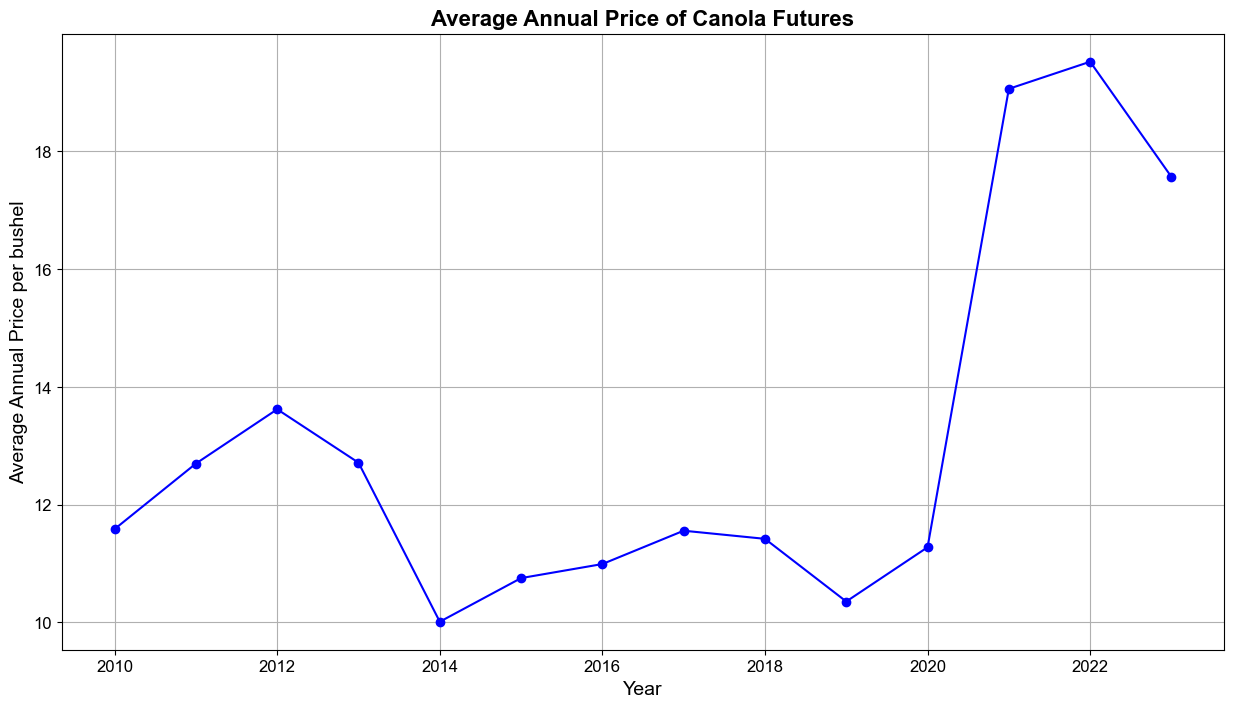

In [81]:
# Display the first few rows of the DataFrame to check the conversion
df_price_by_year.head()
# Plotting the averaged annual price data
plt.figure(figsize=(15, 8))
plt.plot(df_price_by_year['Year'], df_price_by_year['Price'], marker='o', linestyle='-', color='b')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average Annual Price per bushel', fontsize=14)
plt.title('Average Annual Price of Canola Futures', fontsize=16)
plt.grid(True)
plt.show()

# Merge Yield and Stock Price of Canola

In [82]:
# Merge df_data_merged our crop data and df_price_by_year based on the 'Year' column
df_price_merged = df_data_merged.merge(df_price_by_year, on='Year', how='inner')
df_price_merged

,RM,Year,Canola,Price
0,ALEXANDER,2010,14.440130,11.584916
1,ALONSA,2010,17.989536,11.584916
2,ARGYLE,2010,42.970803,11.584916
3,ARMSTRONG,2010,11.419828,11.584916
4,BIFROST-RIVERTON,2010,9.523872,11.584916
...,...,...,...,...
5055,520,2022,47.900000,19.521513
5056,555,2022,39.900000,19.521513
5057,561,2022,28.200000,19.521513
5058,588,2022,35.900000,19.521513


#### Let's add a column 'Value' which is basically the yield x stock price for that year to show valuation for each RM.

In [83]:
# Calculate the 'Value' column by multiplying 'Price' with 'Canola' yield for each RM and year
df_price_merged['Value'] = df_price_merged['Price'] * df_price_merged['Canola']
df_price_merged

,RM,Year,Canola,Price,Value
0,ALEXANDER,2010,14.440130,11.584916,167.287689
1,ALONSA,2010,17.989536,11.584916,208.407259
2,ARGYLE,2010,42.970803,11.584916,497.813137
3,ARMSTRONG,2010,11.419828,11.584916,132.297745
4,BIFROST-RIVERTON,2010,9.523872,11.584916,110.333255
...,...,...,...,...,...
5055,520,2022,47.900000,19.521513,935.080458
5056,555,2022,39.900000,19.521513,778.908356
5057,561,2022,28.200000,19.521513,550.506658
5058,588,2022,35.900000,19.521513,700.822305


In [84]:
df_price_merged[df_price_merged.isnull().any(axis=1)]


,RM,Year,Canola,Price,Value
80,STUARTBURN,2010,NaN,11.584916,NaN
88,WEST INTERLAKE,2010,NaN,11.584916,NaN
89,WEST ST. PAUL,2010,NaN,11.584916,NaN
125,46,2010,NaN,11.584916,NaN
142,76,2010,NaN,11.584916,NaN
...,...,...,...,...,...
4757,WEST INTERLAKE,2022,NaN,19.521513,NaN
4796,51,2022,NaN,19.521513,NaN
4834,110,2022,NaN,19.521513,NaN
4932,279,2022,NaN,19.521513,NaN


In [85]:
# doesn't affect mean, but does affect std and median, need to remove
df_price_merged.dropna()

,RM,Year,Canola,Price,Value
0,ALEXANDER,2010,14.440130,11.584916,167.287689
1,ALONSA,2010,17.989536,11.584916,208.407259
2,ARGYLE,2010,42.970803,11.584916,497.813137
3,ARMSTRONG,2010,11.419828,11.584916,132.297745
4,BIFROST-RIVERTON,2010,9.523872,11.584916,110.333255
...,...,...,...,...,...
5055,520,2022,47.900000,19.521513,935.080458
5056,555,2022,39.900000,19.521513,778.908356
5057,561,2022,28.200000,19.521513,550.506658
5058,588,2022,35.900000,19.521513,700.822305


In [86]:
# slightly out of order, but now that we have a new value column, let's add that to df_gdf so we can visualize it

# Calculate the mean of 'Value' based on groupby 'Year' and 'RM' in df_price_merged
mean_value_by_year_rm = df_price_merged.groupby(['Year', 'RM'])['Value'].mean().reset_index()

# Merge df_gdf with df_price_merged on the 'RM' and 'Year' columns
df_gdf = df_gdf.merge(mean_value_by_year_rm, on=['RM', 'Year'], how='left')

# Merge df_data_merged with df_price_merged on the 'RM' and 'Year' columns
df_data_merged = df_data_merged.merge(mean_value_by_year_rm, on=['RM', 'Year'], how='left')

In [87]:
# Assuming df_price_merged contains your data
# Group by 'Year' and calculate the desired statistics for each column
grouped = df_price_merged.groupby('Year').agg({
    'Canola': ['mean', 'std', 'median'],
    'Price': ['mean', 'std', 'median'],
    'Value': ['mean', 'std', 'median']
})

# Flatten the multi-level column index
grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]

# Reset the index to make 'Year' a regular column
df_value_agg_by_year = grouped.reset_index()

# Display the resulting DataFrame
df_value_agg_by_year

,Year,Canola_mean,Canola_std,Canola_median,Price_mean,Price_std,Price_median,Value_mean,Value_std,Value_median
0,2010,29.442351,7.642709,29.700000,11.584916,0.0,11.584916,341.087150,88.540138,344.071998
1,2011,29.105822,7.178546,30.300000,12.697583,0.0,12.697583,369.573598,91.150185,384.736777
2,2012,25.137916,4.460788,25.215823,13.619305,0.0,13.619305,342.360942,60.752838,343.421993
3,2013,39.099908,5.771026,39.268184,12.712374,0.0,12.712374,497.052653,73.363438,499.191849
4,2014,32.935778,6.667671,32.520000,10.011530,0.0,10.011530,329.737542,66.753591,325.574970
5,2015,37.157303,6.333025,37.745000,10.752499,0.0,10.752499,399.533874,68.095842,405.853087
6,2016,41.255478,5.544293,41.200000,10.991028,0.0,10.991028,453.440110,60.937476,452.830347
7,2017,36.723974,10.350115,37.590000,11.557160,0.0,11.557160,424.424853,119.617939,434.433657
8,2018,38.347932,8.206828,39.100000,11.419069,0.0,11.419069,437.897685,93.714342,446.485606
9,2019,40.914674,7.980801,42.100000,10.354831,0.0,10.354831,423.664531,82.639841,435.938377


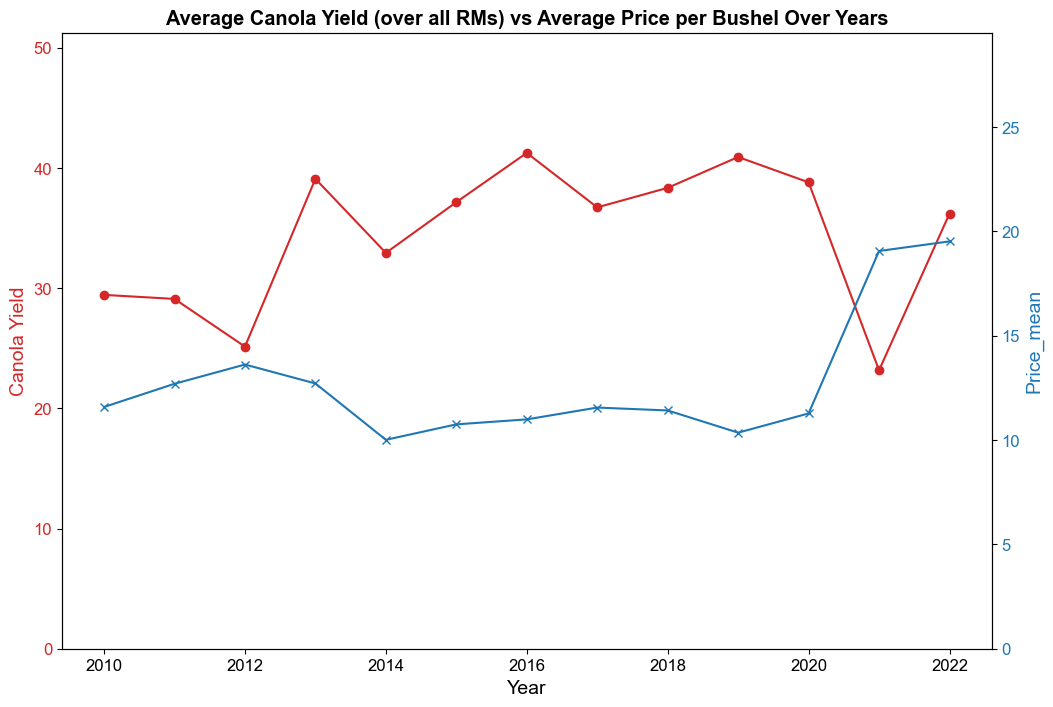

In [88]:
# Create the figure and the line plot for yield and price
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Canola Yield', color=color)
ax1.plot(df_value_agg_by_year['Year'], df_value_agg_by_year['Canola_mean'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Price_mean', color=color)
ax2.plot(df_value_agg_by_year['Year'], df_value_agg_by_year['Price_mean'], color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

# Set y-axis limits to start at zero for both axes
ax1.set_ylim(0, df_value_agg_by_year['Canola_mean'].max() + 10)  # Adjust the upper limit as needed
ax2.set_ylim(0, df_value_agg_by_year['Price_mean'].max() + 10)  # Adjust the upper limit as needed


# Show the plot
plt.title('Average Canola Yield (over all RMs) vs Average Price per Bushel Over Years')
plt.show()

# EDA (Exploratory Data Analysis)

In [89]:
print(f"Number of unique RMs values:", df_data_merged['RM'].nunique())

Number of unique RMs values: 397


In [90]:
print(f"The minimum year is {df_data_merged['Year'].min()} and the maximum year is {df_data_merged['Year'].max()}.")

The minimum year is 1938 and the maximum year is 2022.


## Missing Values

In [91]:
# Check for missing values in crop dataset
missing_values_count = df_data_merged.isnull().sum()
missing_values_count

RM            0
Year          0
Canola    11116
Value     23134
dtype: int64

In [92]:
# Check for missing values in stock price dataset
missing_values_count = df_price_merged.isnull().sum()
missing_values_count

RM         0
Year       0
Canola    77
Price      0
Value     77
dtype: int64

In [93]:
# Calculate the percentage of missing values for each column
missing_values_percentage = round((missing_values_count / len(df_data_merged)) * 100,0)
missing_values_percentage

RM        0.0
Year      0.0
Canola    0.0
Price     0.0
Value     0.0
dtype: float64

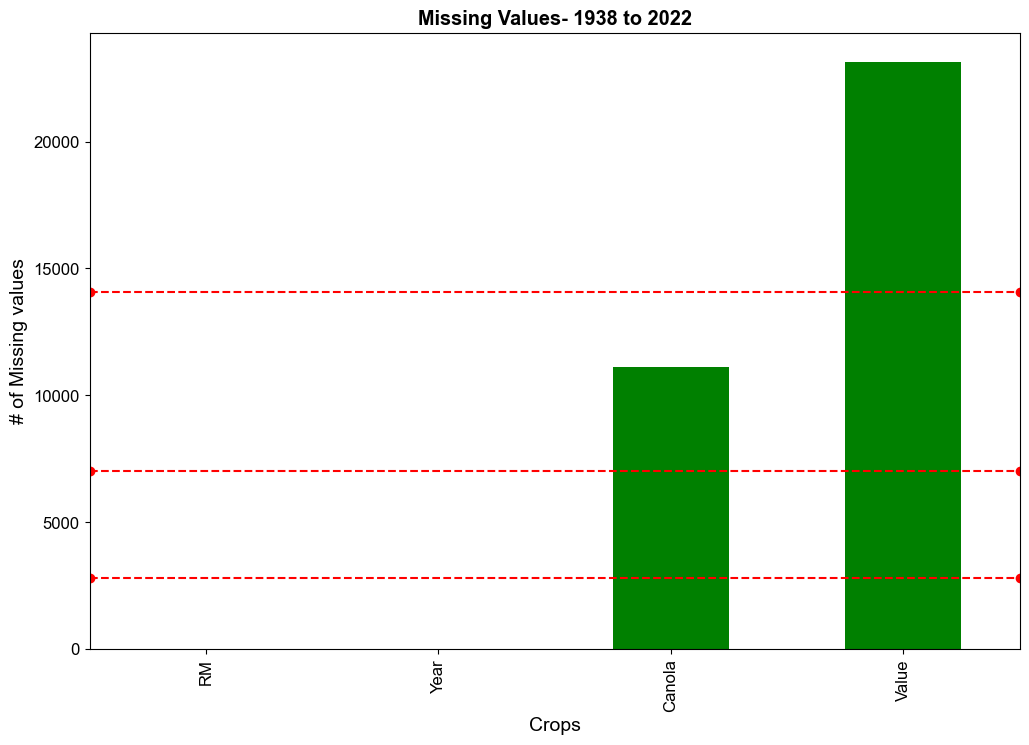

In [94]:
df_data_merged.isna().sum().sort_values().plot(kind='bar', color='green')
plt.title('Missing Values- 1938 to 2022')
plt.xlabel('Crops')
plt.ylabel('# of Missing values')
plt.axhline(len(df_data_merged)/2, linestyle='--', color='red') # 50% of values
plt.axhline(len(df_data_merged)/4, linestyle='--', color='red') # 25% of values
plt.axhline(len(df_data_merged)/10, linestyle='--', color='red') # 10% of values
plt.show()

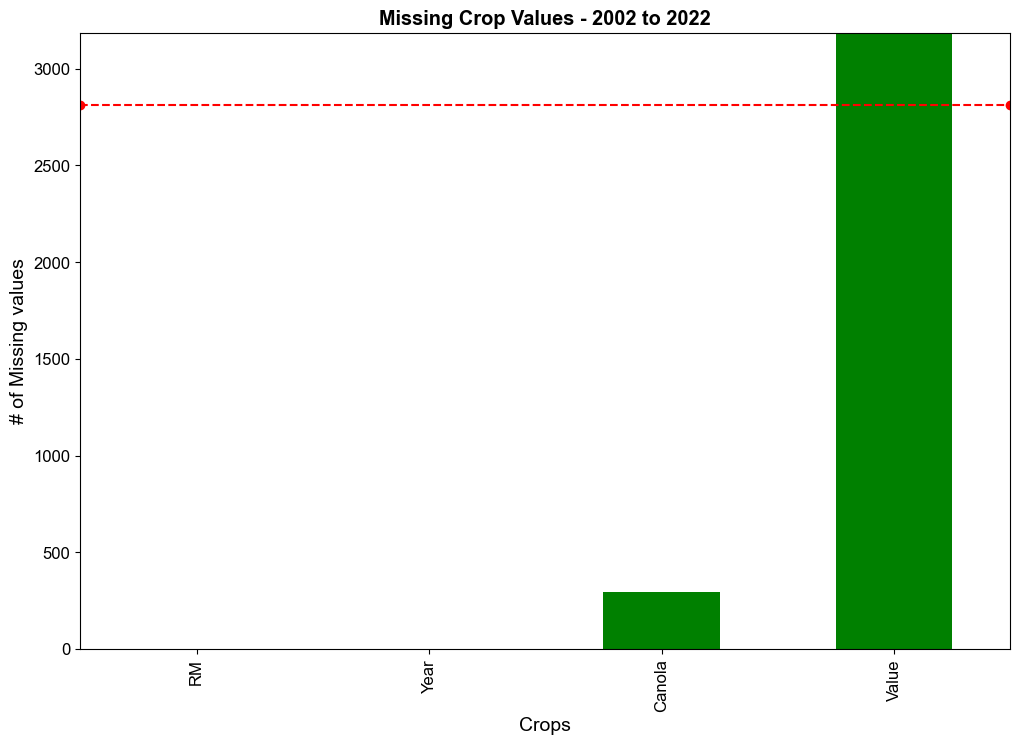

In [95]:
# Filter the DataFrame for 'Year' > 2001 and calculate missing values counts
missing_values_count_filtered = df_data_merged[df_data_merged['Year'] > 2001].isna().sum().sort_values()

# Get the minimum and maximum values of the missing values counts
y_min = missing_values_count_filtered.min()
y_max = missing_values_count_filtered.max()

# Plot the data with dynamic y-axis limits
ax = missing_values_count_filtered.plot(kind='bar', color='green')
ax.set_title('Missing Crop Values - 2002 to 2022')
ax.set_xlabel('Crops')
ax.set_ylabel('# of Missing values')
ax.axhline(len(df_data_merged)/2, linestyle='--', color='red')  # 50% of values
ax.axhline(len(df_data_merged)/4, linestyle='--', color='red')  # 25% of values
ax.axhline(len(df_data_merged)/10, linestyle='--', color='red')  # 10% of values
ax.set_ylim(y_min, y_max)  # Set y-axis limits based on data

plt.show()


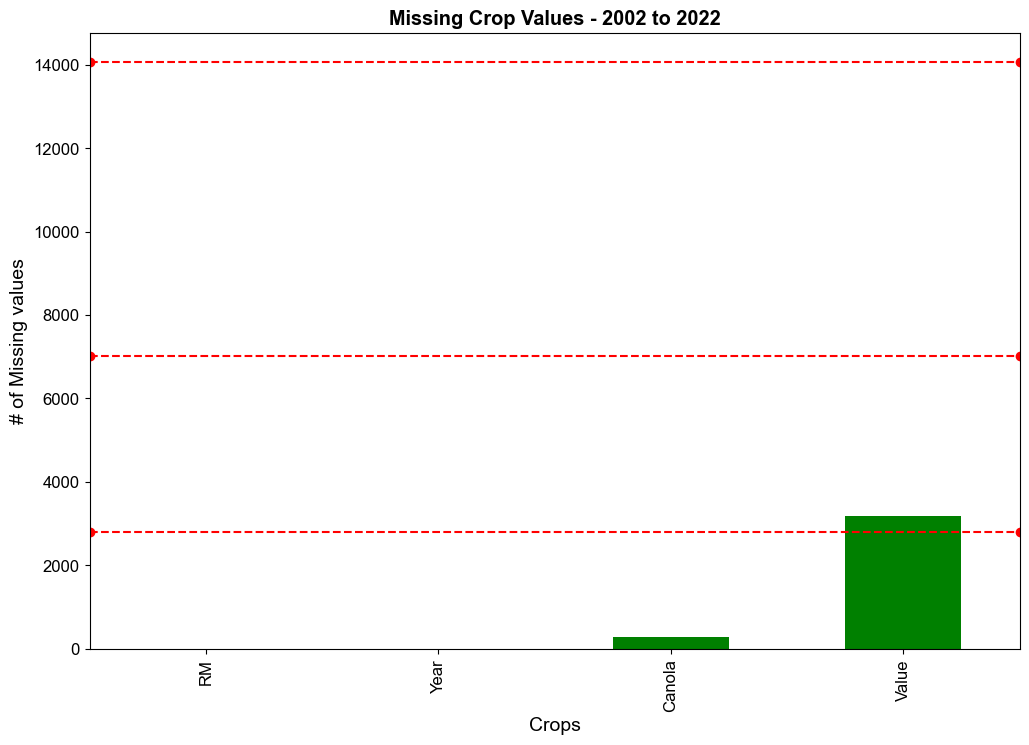

In [96]:
df_data_merged.loc[df_data_merged['Year']>2001].isna().sum().sort_values().plot(kind='bar', color='green')
plt.title('Missing Crop Values - 2002 to 2022')
plt.xlabel('Crops')
plt.ylabel('# of Missing values')
plt.axhline(len(df_data_merged)/2, linestyle='--', color='red') # 50% of values
plt.axhline(len(df_data_merged)/4, linestyle='--', color='red') # 25% of values
plt.axhline(len(df_data_merged)/10, linestyle='--', color='red') # 10% of values
plt.show()

In [97]:
# Select rows where 'Year' is greater than 2001 and then calculate missing values counts
missing_values_count = df_data_merged[df_data_merged['Year'] > 2001].isnull().sum()

# Display the missing values counts
missing_values_count


RM           0
Year         0
Canola     294
Value     3186
dtype: int64

#### This helps illustrate if we utilize only the last 20 years (since 2002) there is a marked decrease is missig values.

## Outlier Detection

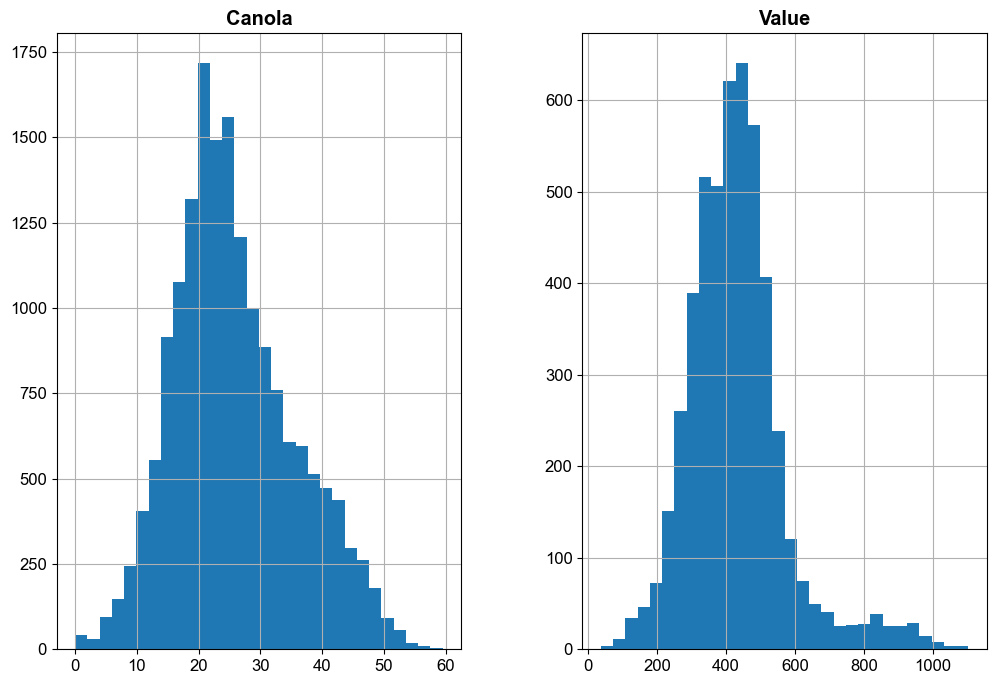

In [98]:
numerical_columns = df_data_merged.select_dtypes(include='number').drop(columns=['Year']).columns
# view distributions
df_data_merged[numerical_columns].hist(bins=30)
plt.show()

### Boxplots

<AxesSubplot:>

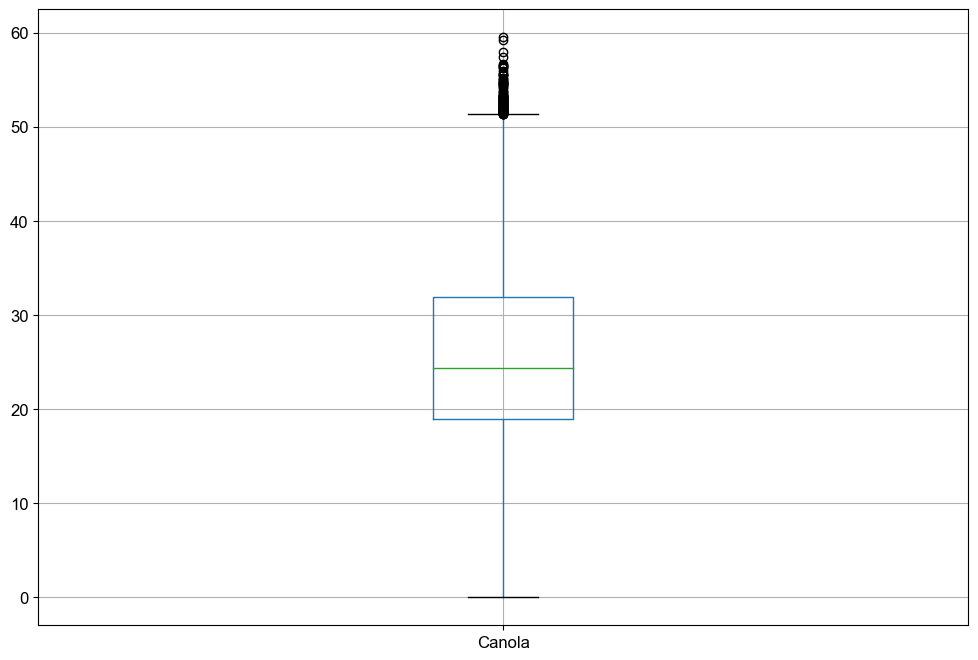

In [99]:
df_data_merged[target_crop].boxplot()

In [100]:
df_data_merged.head()

,RM,Year,Canola,Value
0,ALEXANDER,1993,11.067092,NaN
1,ALEXANDER,1994,12.742588,NaN
2,ALEXANDER,1995,27.337040,NaN
3,ALEXANDER,1996,33.304157,NaN
4,ALEXANDER,1997,28.718589,NaN


In [101]:
# another correlation visualization with more specific focus
numerical_columns = df_price_merged.select_dtypes(include='number').columns  # Use square brackets [] to access columns
# Show all correlation values
df_corr = df_price_merged[numerical_columns].corr().round(1)

#df_corr = corr_df.round(1)
# Mask to matrix
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Viz
df_corr_viz = df_corr.mask(mask).dropna(how='all').dropna(how='all')
# colour variable https://plotly.com/python/colorscales/
fig = px.imshow(df_corr_viz, text_auto=True, color_continuous_scale=[(0.00, "black"),   (0.33, "black"),
                                                     (0.33, "white"), (0.66, "white"),
                                                     (0.66, "blue"),  (1.00, "blue")])
# unable to write to image, simply take screenshot
fig.show()

# Visualizations

## GIS Visualization

In [102]:
df_gdf.shape # should be 27909,12 with SK and MB

(27909, 5)

In [103]:
if show_maps:
    # show all RM shapefiles
    # Create a Folium Map centered on the data
    m = folium.Map(location=[gdf.centroid.y.mean(), gdf.centroid.x.mean()], zoom_start=8)

    # Add GeoJSON data (your GeoDataFrame) with only borders and no color
    for idx, row in gdf.iterrows():
        folium.GeoJson(row.geometry.__geo_interface__,
                    style_function=lambda x: {'color': 'blue', 'weight': 1},
                    ).add_to(m)

    # Display the map
    m

### Explore GIS Data

In [104]:
print(df_gdf.loc[df_gdf['Year'] == 2020].shape) # should be 391,12

(391, 5)


In [105]:
# what year has the most RM's ?
df_gdf.groupby('Year')['RM'].nunique().sort_values(ascending=False)

Year
2020    391
2000    391
2003    390
2010    390
1996    390
       ... 
1964    296
1963    296
1962    296
1992    295
1991    295
Name: RM, Length: 85, dtype: int64

In [106]:
# # quick test plot
# subset = df_gdf.loc[df_gdf['Year'] == 2020]
# subset.plot()

In [107]:
# quick and simple plot with legend but only 1 year
# df_gdf.loc[df_gdf['Year']==2020].plot(column='Canola',
#                                  legend=True,
#                                  cmap='Greens')

In [108]:
# export graph to html for interactivity for 1 year of Canola
# m=df_gdf.loc[df_gdf['Year']==2021].explore(column='Canola',
#                                  legend=True,
#                                  cmap='Greens',
#                                  tooltip= ['Canola', 'RM'],
#                                  tiles='Stamen Toner') # Plot() is good for showing up in GitHub, Explore() is good for interactive map and saving as HTML

# # Adding a title with dark orange color to the folium map
# title_html = '''
#                  <h3 align="center" style="font-size:30px; color:Blue;"><b> Canola Yield in 2021 </b></h3>
#              '''
# m.get_root().html.add_child(folium.Element(title_html))
# m.save(file_path + 'Visuals/Canola_2021.html')

#### Output for last 20 years - Canola Yields

In [109]:
# Convert the DataFrame to GeoJSON format
# geo_json_data = json.loads(ds.to_json()) # takes 5 minutes

In [110]:
if show_maps:
    # Get unique years
    unique_years = sorted(df_gdf['Year'].dropna().unique())
    # Get the last years from the sorted unique_years list
    unique_years = unique_years[-21:]

    # Get global min and max values for 'Canola' for the last years, ensures all charts have the same scale
    global_min = df_gdf[df_gdf['Year'].isin(unique_years)]['Canola'].min()
    global_max = df_gdf[df_gdf['Year'].isin(unique_years)]['Canola'].max()

    # Create subplots
    n_years = len(unique_years)
    n_cols = 3  # Number of columns for subplots
    n_rows = int(n_years / n_cols) + (n_years % n_cols > 0)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    # Flatten the axes array and remove extra subplots
    axes = axes.flatten()
    for ax in axes[n_years:]:
        ax.remove()

    # Plot data for each year
    for year, ax in zip(unique_years, axes):
        df_gdf[df_gdf['Year'] == year].plot(column='Canola',
                                    legend=False,
                                    cmap='Greens',
                                    ax=ax,
                                    vmin=global_min,  # Set min value for the colormap
                                    vmax=global_max)  # Set max value for the colormap
        ax.set_title(f'Canola Yield in {year}')

        # Hide x and y-axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a common legend for all subplots
    fig.subplots_adjust(right=0.8, hspace=0.4, wspace=0.4)
    cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=global_min, vmax=global_max))
    sm.set_array([])
    fig.colorbar(sm, cax=cax)

    # Adjust the layout manually
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.8, hspace=0.4, wspace=0.4)

    plt.show()


#### Output Since 2010 - Canola Values

In [111]:
if show_maps:
    # Get unique years
    unique_years = sorted(df_gdf['Year'].dropna().unique())
    # Get the last years from the sorted unique_years list
    unique_years = unique_years[-12:]

    # Get global min and max values for 'Canola' for the last years, ensures all charts have the same scale
    global_min = df_gdf[df_gdf['Year'].isin(unique_years)]['Value'].min()
    global_max = df_gdf[df_gdf['Year'].isin(unique_years)]['Value'].max()

    # Create subplots
    n_years = len(unique_years)
    n_cols = 3  # Number of columns for subplots
    n_rows = int(n_years / n_cols) + (n_years % n_cols > 0)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))

    # Flatten the axes array and remove extra subplots
    axes = axes.flatten()
    for ax in axes[n_years:]:
        ax.remove()

    # Plot data for each year
    for year, ax in zip(unique_years, axes):
        df_gdf[df_gdf['Year'] == year].plot(column='Value',
                                    legend=False,
                                    cmap='Greens',
                                    ax=ax,
                                    vmin=global_min,  # Set min value for the colormap
                                    vmax=global_max)  # Set max value for the colormap
        ax.set_title(f'Canola Valuation in {year}')

        # Hide x and y-axis labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])

    # Create a common legend for all subplots
    fig.subplots_adjust(right=0.8, hspace=0.4, wspace=0.4)
    cax = fig.add_axes([0.85, 0.2, 0.03, 0.6])
    sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=global_min, vmax=global_max))
    sm.set_array([])
    fig.colorbar(sm, cax=cax)

    # Adjust the layout manually
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.8, hspace=0.4, wspace=0.4)

    plt.show()

## Aggregations

In [112]:
# Let's only use the Canola Data from past 20 years to minimize missing values
df_yield_20yrs = df_data_merged.loc[df_data_merged['Year'] > 2002].sort_values(['RM', 'Year'])
df_yield_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True)

,Canola,Value
RM,,
1,28.857500,401.699430
10,21.931500,333.428196
100,30.436842,445.459645
101,26.350526,368.376844
102,31.061500,441.849929
...,...,...
WHITEHEAD,33.041511,441.705000
WHITEMOUTH,32.618159,455.102235
WINNIPEG,31.971341,413.186982


# Canola RMs

## Canola RM's by Average Yield

In [113]:
if show_maps:
    # display average canola yield 
    pd.merge(
        gdf,
        df_yield_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True),
        on='RM').explore(
            column='Canola',
            cmap='RdYlGn')

In [114]:
if show_maps:
    # display average canola yield std
    pd.merge(
        gdf,
        df_yield_20yrs.drop(columns=['Year']).groupby('RM').std(numeric_only=True),
        on='RM').explore(
            column='Canola',
            cmap='RdYlGn_r')

In [115]:
# # Create a GeoDataFrame with the 'geometry' column
# gdf_yield = gpd.GeoDataFrame(
#     df_yield_20yrs.drop(columns=['Year']).groupby('RM').std(numeric_only=True),
#     geometry=df_yield['geometry'].apply(Polygon),  # Assuming 'geometry' column contains Polygon geometries
#     crs='EPSG:4326'  # Replace with the appropriate CRS for your data
# )

In [116]:
df_yield_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True).sort_values(by='RM')

,Canola,Value
RM,,
1,28.857500,401.699430
10,21.931500,333.428196
100,30.436842,445.459645
101,26.350526,368.376844
102,31.061500,441.849929
...,...,...
WHITEHEAD,33.041511,441.705000
WHITEMOUTH,32.618159,455.102235
WINNIPEG,31.971341,413.186982


In [117]:
# Merge df_yield_20yrs with gdf to get the geometry
gdf_yield = gdf.merge(df_yield_20yrs.drop(columns=['Year']).groupby('RM').mean(numeric_only=True), left_on='RM', right_index=True)

In [118]:
gdf_yield.sort_values(by='RM')

,RM,geometry,Canola,Value
34,1,"POLYGON ((-101.39218 49.18548, -101.39223 49.1...",28.857500,401.699430
12,10,"POLYGON ((-104.81097 49.06477, -104.81097 49.0...",21.931500,333.428196
94,100,"POLYGON ((-105.25475 50.04683, -105.25470 50.0...",30.436842,445.459645
59,101,"POLYGON ((-105.61946 50.04680, -105.61823 50.0...",26.350526,368.376844
119,102,"POLYGON ((-105.69176 49.94815, -105.69177 49.9...",31.061500,441.849929
...,...,...,...,...
112,WHITEHEAD,"POLYGON ((-100.46277 49.88662, -100.46235 49.8...",33.041511,441.705000
98,WHITEMOUTH,"POLYGON ((-96.02118 50.11898, -96.02070 50.118...",32.618159,455.102235
119,WINNIPEG,"POLYGON ((-97.18411 49.97560, -97.18369 49.975...",31.971341,413.186982
143,WOODLANDS,"POLYGON ((-97.45990 50.41850, -97.45980 50.411...",32.875363,400.361921


In [119]:
# export graph to html for interactivity
m=gdf_yield.explore(column='Canola',
                                 legend=True,
                                 cmap='Greens',
                                 tooltip= ['Canola', 'RM'],
                                 tiles='Stamen Toner') # Plot() is good for showing up in GitHub, Explore() is good for interactive map and saving as HTML

# Adding a title with dark orange color to the folium map
title_html = '''
                 <h3 align="center" style="font-size:30px; color:Blue;"><b> All Canola Mean Yield from 2002-2022 </b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
m.save(file_path + 'Visuals/Canola_AllYields.html')

## Top 10 Canola Average Yield

In [120]:
# Best Canola Average Yield
df_top10_yield = df_yield_20yrs.drop(columns='Year').groupby('RM').mean(numeric_only=True).sort_values('Canola', ascending=False).head(10)
df_top10_yield

,Canola,Value
RM,,
SWAN VALLEY WEST,42.681213,553.333615
LOUISE,42.033234,554.761563
HILLSBURG-ROBLIN-SHELL RIVER,41.558253,561.917317
VICTORIA,41.360553,522.671936
RHINELAND,41.025401,564.825765
ROLAND,40.834704,542.052420
LORNE,40.664508,522.697827
STANLEY,40.549979,532.789336
DUFFERIN,40.118366,535.204543


In [121]:
if show_maps:
    pd.merge(
        gdf,
        df_top10_yield,
        on='RM').explore(column='Canola', legend='True', scheme='quantiles', cmap='cool')

In [122]:
# Verified df_gdf and df_data_merged give same result
#df_yield = df_gdf[df_gdf['Year'] > 2002][['RM', 'geometry', 'Canola']].groupby('RM').agg({'Canola': 'mean', 'geometry': 'first'}).reset_index().nlargest(10, 'Canola')
#df_yield.rename(columns={'Canola': 'Canola_mean'}, inplace=True)
df_yield = df_gdf[df_gdf['Year'] > 2002].groupby('RM').agg({'Canola': ['mean', 'std'], 'geometry': 'first'}).reset_index()
df_yield.columns = ['RM', 'Canola_mean', 'Canola_std', 'geometry']
df_yield = df_yield.sort_values(by='Canola_mean', ascending=False).head(10)
df_yield

,RM,Canola_mean,Canola_std,geometry
378,SWAN VALLEY WEST,42.681213,9.009248,"POLYGON ((-101.31150 52.31802, -101.29991 52.3..."
337,LOUISE,42.033234,7.566462,"POLYGON ((-98.81757 49.33984, -98.81757 49.339..."
330,HILLSBURG-ROBLIN-SHELL RIVER,41.558253,10.466401,"POLYGON ((-101.38880 51.62136, -101.37722 51.6..."
382,VICTORIA,41.360553,6.738479,"POLYGON ((-98.77953 49.79823, -98.77946 49.790..."
358,RHINELAND,41.025401,10.210209,"POLYGON ((-97.45988 49.17636, -97.45988 49.170..."
363,ROLAND,40.834704,10.856313,"POLYGON ((-97.73078 49.44359, -97.73076 49.436..."
336,LORNE,40.664508,5.862026,"POLYGON ((-98.54471 49.53285, -98.54470 49.532..."
374,STANLEY,40.549979,8.804886,"POLYGON ((-97.88824 49.26615, -97.87717 49.266..."
311,DUFFERIN,40.118366,9.542822,"POLYGON ((-97.73260 49.62086, -97.73259 49.613..."
380,THOMPSON,40.036638,7.544904,"POLYGON ((-97.82322 55.75650, -97.82778 55.753..."


In [123]:
# Create a GeoDataFrame with the 'geometry' column
gdf_yield = gpd.GeoDataFrame(
    df_yield,
    geometry=df_yield['geometry'].apply(Polygon),  # Assuming 'geometry' column contains Polygon geometries
    crs='EPSG:4326'  # Replace with the appropriate CRS for your data
)

In [124]:
# export graph to html for interactivity
m=gdf_yield.explore(column='Canola_mean',
                                 legend=True,
                                 scheme='quantiles', cmap='cool',
                                 tooltip= ['Canola_mean', 'Canola_std', 'RM'],
                                 tiles='Stamen Toner') # Plot() is good for showing up in GitHub, Explore() is good for interactive map and saving as HTML

# Adding a title with dark orange color to the folium map
title_html = '''
                 <h3 align="center" style="font-size:30px; color:Blue;"><b> Top Canola Mean Yield from 2002-2022 </b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
m.save(file_path + 'Visuals/Canola_TopYields.html')

## Canola RM's by Average Value

In [125]:
numerical_features=['Value']

agg_funcs = {
    column: ['mean', 'std', 'median'] for column in numerical_features
}

df_value_agg = df_price_merged.set_index('RM')[numerical_features].groupby('RM').agg(agg_funcs)

# Optionally, to flatten the multi-level columns:
df_value_agg.columns = ['_'.join(col).strip() for col in df_value_agg.columns.values]

df_value_agg

,Value_mean,Value_std,Value_median
RM,,,
1,401.699430,145.268282,352.811994
10,333.428196,118.326225,304.851102
100,445.459645,161.421993,435.817763
101,368.376844,114.468603,325.443473
102,441.849929,94.377674,423.325898
...,...,...,...
WHITEHEAD,441.705000,115.008026,433.112356
WHITEMOUTH,455.102235,179.707626,442.966686
WINNIPEG,413.186982,162.218974,398.354681


In [126]:
df_value_agg[df_value_agg.isna().any(axis=1)]

,Value_mean,Value_std,Value_median
RM,,,
COLDWELL,NaN,NaN,NaN
EAST ST. PAUL,NaN,NaN,NaN


In [127]:
df_value_agg = df_value_agg.dropna()

In [128]:
if show_maps:
    # display canola value
    pd.merge(
        gdf,
        df_value_agg,
        on='RM').explore(
            column='Value_mean',
            cmap='RdYlGn')

In [129]:
# Merge the GeoDataFrame gdf with df_value_agg based on the 'RM' column
#merged_gdf = gdf.merge(df_value_agg, left_on='RM', right_index=True)

# Create a Folium map from the merged GeoDataFrame
m = gdf.merge(df_value_agg, left_on='RM', right_index=True).explore(column='Value_mean', legend=True, cmap='Greens')

# Adding a title with dark orange color to the Folium map
title_html = '''
                 <h3 align="center" style="font-size:30px; color:Blue;"><b> Top Canola Mean Values from 2010-2022 </b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Save the Folium map as an HTML file
m.save(file_path + 'Visuals/Canola_AllValues.html')

## Top 10 Canola Value RM's 

In [130]:
top_10_value_rms = df_value_agg.drop(columns=['Value_median']).sort_values(by='Value_mean', ascending=False).head(10)

# Round the 'Value_mean' column to 2 decimals
top_10_value_rms['Value_mean'] = top_10_value_rms['Value_mean'].round(2)
top_10_value_rms['Value_std'] = top_10_value_rms['Value_std'].round(2)

# Print the top 10 RM values by Value_mean
top_10_value_rms

# Expect:
# RM                             Value_mean	Value_std
# REYNOLDS	                        629.82	313.03
# 271	                            566.43	191.95
# RHINELAND	                        564.83	148.40
# HILLSBURG-ROBLIN-SHELL RIVER	    561.92	171.38
# LOUISE	                        554.76	111.71
# SWAN VALLEY WEST	                553.33	170.97
# 303	                            550.63	177.42
# MONTCALM	                        544.91	141.36
# ROLAND	                        542.05	155.55
# 493	                            540.99	179.66


,Value_mean,Value_std
RM,,
REYNOLDS,629.82,313.03
271,566.43,191.95
RHINELAND,564.83,148.40
HILLSBURG-ROBLIN-SHELL RIVER,561.92,171.38
LOUISE,554.76,111.71
SWAN VALLEY WEST,553.33,170.97
303,550.63,177.42
MONTCALM,544.91,141.36
ROLAND,542.05,155.55


In [131]:
if show_maps:
    # display top 10 canola value
    pd.merge(
        gdf,
        top_10_value_rms,
        on='RM').explore(column='Value_mean', legend='True', scheme='quantiles', cmap='cool')

In [132]:
# Merge gdf with top_10_value_rms to get the geometry
gdf_yield = gdf.merge(top_10_value_rms, on='RM')

In [133]:
gdf_yield

,RM,geometry,Value_mean,Value_std
0,303,"POLYGON ((-102.00665 51.88183, -102.00664 51.8...",550.63,177.42
1,493,"POLYGON ((-106.02867 53.56164, -106.02867 53.5...",540.99,179.66
2,271,"MULTIPOLYGON (((-101.57052 51.65479, -101.5705...",566.43,191.95
3,HILLSBURG-ROBLIN-SHELL RIVER,"POLYGON ((-101.38880 51.62136, -101.37722 51.6...",561.92,171.38
4,LOUISE,"POLYGON ((-98.81757 49.33984, -98.81757 49.339...",554.76,111.71
5,REYNOLDS,"POLYGON ((-95.68570 49.92341, -95.68584 49.916...",629.82,313.03
6,SWAN VALLEY WEST,"POLYGON ((-101.31150 52.31802, -101.29991 52.3...",553.33,170.97
7,ROLAND,"POLYGON ((-97.73078 49.44359, -97.73076 49.436...",542.05,155.55
8,MONTCALM,"POLYGON ((-97.35108 49.35453, -97.34909 49.354...",544.91,141.36
9,RHINELAND,"POLYGON ((-97.45988 49.17636, -97.45988 49.170...",564.83,148.40


In [134]:
# export graph to html for interactivity
m=gdf_yield.explore(column='Value_mean',
                                 legend=True,
                                 scheme='quantiles', cmap='cool',
                                 tooltip= ['Value_mean', 'Value_std', 'RM'],
                                 tiles='Stamen Toner') # Plot() is good for showing up in GitHub, Explore() is good for interactive map and saving as HTML

# Adding a title with dark orange color to the folium map
title_html = '''
                 <h3 align="center" style="font-size:30px; color:Blue;"><b> Top Canola Mean Value from 2010-2022 </b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))
m.save(file_path + 'Visuals/Canola_TopValues.html')

# Clustering Methods